# Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm import tqdm
import itertools
from collections import defaultdict
import string

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.extmath import density
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from __future__ import unicode_literals
from hazm import Normalizer, sent_tokenize, word_tokenize, Stemmer, Lemmatizer, POSTagger, Chunker, tree2brackets, DependencyParser, stopwords_list
from nltk.util import pad_sequence, bigrams, ngrams, everygrams

sns.set_theme(style="white")
%matplotlib inline


---

# Read Train and Test Datasets

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


label_column = 'label'
text_column = 'text'
path_column = 'path'

In [3]:
train.head()

,path,text,label
0,./email/ok_training/hamtraining (88).txt,﻿تا امثال شماها هستند مملکت ما همچنان با مشکلا...,ham
1,./email/ok_training/hamtraining (235).txt,﻿سامان جان:\nاین که بگی این شعاره کاری رو حل ن...,ham
2,./email/ok_training/hamtraining (123).txt,﻿خانم علی نژاد سلام،\n\nمدتی بود میخواستم برای...,ham
3,./email/ok_training/hamtraining (145).txt,﻿ >> >> 2013/8/10 Faramarz Dehgan <faramarzdeh...,ham
4,./email/ok_training/hamtraining (162).txt,﻿ >> >>> >> >>> 2013/11/9 Faramarz Dehgan <far...,ham


---

# Dataset Cleaning (Part 1)

## Remove URLs And HTMLs

In [4]:
def remove_URL(text):
    text = str(text)
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_HTML(text):
    text = str(text)
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

## Remove Emojis

In [5]:
def remove_emoji(text):
    text = str(text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

## Remove Punctuations

In [6]:
def remove_punctuations(text):
    text = str(text)
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

## Normalization

In [7]:
normalizer = Normalizer()
def normalize_text(text):
    return normalizer.normalize(text)

## Remove Stopwords

In [8]:
def remove_stopwords(text):
    sws = stopwords_list().copy()
    sws = set(sws)
    sws = sws.union({})
    text = [word.lower() for word in text.split() if word.lower() not in sws]

    return " ".join(text)

## Remove Numbers

In [9]:
def remove_number(text):
    text = str(text)
    result = re.sub(r'\d+','', text)
    return result

## Clean up Pipline (Part 1)

In [10]:
def clean_up_pipeline(data):
    cleaning_functions = [
        str,
        str.strip,
        str.lower,
        remove_number,
        remove_URL,
        remove_HTML,
        remove_emoji,
        remove_punctuations,
        remove_stopwords
    ]
    
    for function in cleaning_functions:
        data.loc[:, text_column] = data[text_column].map(function)
    
    return data

train = clean_up_pipeline(train)
test = clean_up_pipeline(test)

---

# Dataset Cleaning (Part 2)

## Word Tokenization (hazm `word_tokenize` function)

In [11]:
print('Train Texts Tokenization ...')
train_texts_tokens = [word_tokenize(text) for text in tqdm(train[text_column].tolist())]

print('Test Texts Tokenization ...')
test_texts_tokens = [word_tokenize(text) for text in tqdm(test[text_column].tolist())]

Train Texts Tokenization ...


100%|██████████| 600/600 [00:00<00:00, 1569.76it/s]


Test Texts Tokenization ...


100%|██████████| 400/400 [00:00<00:00, 8797.93it/s]


## Lemmatization / Stemming (Lemmatization used in this case)

In [12]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()

# lemmatized_train_texts_tokens = [list(map(stemmer.stem, tokens)) for tokens in lemmatized_train_texts_tokens]
# lemmatized_test_texts_tokens = [list(map(stemmer.stem, tokens)) for tokens in lemmatized_test_texts_tokens]

lemmatized_train_texts_tokens = [list(map(lemmatizer.lemmatize, tokens)) for tokens in train_texts_tokens]
lemmatized_test_texts_tokens = [list(map(lemmatizer.lemmatize, tokens)) for tokens in test_texts_tokens]

lemmatized_train_text = [" ".join(tokens) for tokens in lemmatized_train_texts_tokens]
lemmatized_test_text = [" ".join(tokens) for tokens in lemmatized_test_texts_tokens]

train[text_column] = lemmatized_train_text
test[text_column] = lemmatized_test_text

---

# Dataset Visualization

## WordCloud (Farsi)

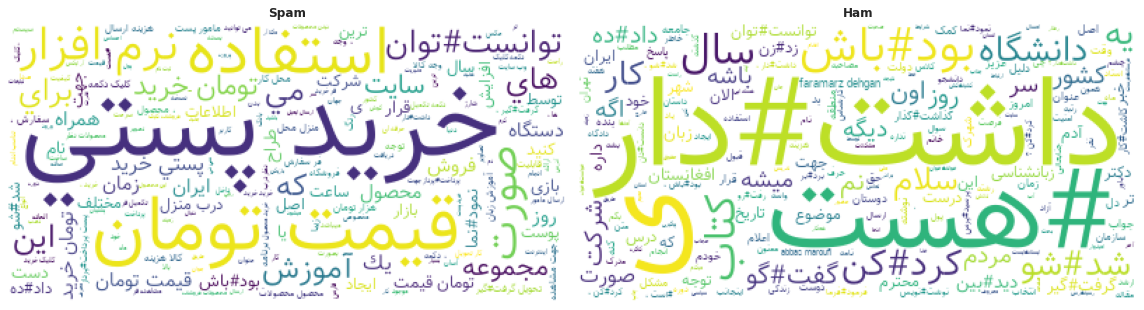

In [13]:
def aggregate_tokens(tokens_series: pd.Series):
    return list(itertools.chain.from_iterable(tokens_series.tolist()))

def data_tokenize(series: pd.Series, tokenizer):
    tokens_series = series.apply(lambda txt: tokenizer(str(txt)))
    return aggregate_tokens(tokens_series)

def ham_spam_data_split(data):
    spam_data = train.loc[train[label_column] == 'spam', :]
    ham_data = train.loc[train[label_column] == 'ham', :]    

    return ham_data, spam_data

ham_data, spam_data = ham_spam_data_split(train)

spam_data_tokens = data_tokenize(spam_data[text_column], word_tokenize)
ham_data_tokens = data_tokenize(ham_data[text_column], word_tokenize)

from wordcloud_fa import WordCloudFa

wc_bg_color = "white"
spam_word_cloud = WordCloudFa(background_color=wc_bg_color,).generate(
    " ".join(spam_data_tokens)
)
                            
ham_word_cloud = WordCloudFa(background_color=wc_bg_color,).generate(
    " ".join(ham_data_tokens)
)

plt.figure(figsize=(16, 8 ))

plt.subplot(1, 2, 1)
plt.imshow(spam_word_cloud)
plt.title('Spam', fontweight="bold")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_word_cloud)
plt.title('Ham', fontweight="bold")
plt.axis('off')

plt.tight_layout()
plt.show()

## n-Gram Barcharts

In [15]:
def get_top_k_results(dictionary, k):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:k]

def calculate_text_data_ngram(data, n):
    texts_ngrams = data[text_column].apply(lambda txt: list(ngrams(txt.split(" "), n=n))).tolist()
    aggregated_ngrams = list(itertools.chain.from_iterable(texts_ngrams))
    
    aggregated_ngrams = list(map(lambda str_tuple: " ".join(list(str_tuple)), aggregated_ngrams))
    return aggregated_ngrams

def build_word_to_count_dictionary(word_list):
    stopwords_dict = defaultdict(int)

    for word in word_list:
        stopwords_dict[word] += 1

    return stopwords_dict

ham_data, spam_data = ham_spam_data_split(train)

k = 10
max_n = 3

plt.figure(figsize=(max_n * 6, 12))
for i in range(max_n):
    
    i_gram = i + 1
    spam_n_gram_top_k = get_top_k_results(build_word_to_count_dictionary(calculate_text_data_ngram(spam_data, n=i_gram)), k=k)
    ham_n_gram_top_k = get_top_k_results(build_word_to_count_dictionary(calculate_text_data_ngram(ham_data, n=i_gram)), k=k)

    X = 'n-Gram'
    Y = 'Frequency'
    plt.subplot(max_n, 2, i * 2 + 1)
    sns.barplot(x=Y, y=X, data=pd.DataFrame(spam_n_gram_top_k, columns=[X, Y]), orient='h')
    plt.yticks(rotation=45)
    plt.ylabel('')
    plt.title('Spam', fontweight="bold")

    plt.subplot(max_n, 2, i * 2 + 2)
    sns.barplot(x=Y, y=X, data=pd.DataFrame(ham_n_gram_top_k, columns=[X, Y]), orient='h')
    plt.yticks(rotation=45)
    plt.ylabel('')
    plt.title('Ham', fontweight="bold")
    
plt.tight_layout()
plt.show()

KeyError: 'Text'

<Figure size 1296x864 with 0 Axes>

---

# Feature Extraction

## TF-IDF Vectorizer

In [ ]:
train_text = [text.split(" ") for text in train[text_column].tolist()]
test_text = [text.split(" ") for text in test[text_column].tolist()]

vectorizer = TfidfVectorizer(ngram_range=(1, 5), token_pattern=r'\w{1,}',)
x = vectorizer.fit_transform(train[text_column])
y = train[label_column]

x_test = vectorizer.transform(test[text_column])

---

# Split Train Dataset To Train and Validation Parts

In [ ]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=42)

---

## Model Training

In [ ]:
from time import time

def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_validation)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_validation, pred)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    print(classification_report(y_validation, pred, target_names=['Ham', 'Spam']))

    print("confusion matrix:")
    print(confusion_matrix(y_validation, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=500, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=500, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)

---

# Predict On Test Data (Save Prediction to `submission.csv`)

In [ ]:
clf = MultinomialNB(alpha=1 * 1e1)

clf.fit(x_train, y_train)
y_validation_predicted = clf.predict(x_validation)

score = accuracy_score(y_validation, y_validation_predicted)
print(f'Accuracy On Validation Data: {score}')
y_test_predicted = clf.predict(x_test)

paths = test[path_column].map(lambda s: s.replace("./email/test/", "")).tolist()
submition_predicts = pd.DataFrame(list(zip(paths, y_test_predicted)), columns=['filename', 'prediction'])
pd.DataFrame.to_csv(submition_predicts,
                    'submission.csv',
                    index=False,
                    index_label=False)


0.9333333333333333
